In [25]:
import numpy as np
import scipy
from scipy import integrate
import sympy as sp
import matplotlib.pyplot as plt

Linear solutions

The poisson-boltzmann equation assumes that the charge distribution in a poisson equation is a boltzmann type distribution. Below is the generalised solution for a 1-dimensional problem. Z+ and Z- are the charge numbers of the ions, C0+ and C0- are their respective concentrations. This linear approximation is valid for small zeta potential values, less than thermal voltage (kT/e

In [17]:
def fullanalyticalsol():
    v = sp.Function("\u03A8")
    v0 = sp.symbols("\u03A8_0")
    x = sp.symbols("x")
    e = sp.symbols("e")
    Na = sp.symbols("N_A")
    epsilon = sp.symbols("\u03B5")
    zplus = sp.symbols("z_+")
    c0plus = sp.symbols("C_0+")
    C2 = sp.symbols("C2")
    k = sp.symbols("k")
    T = sp.symbols("T")
    zminus = sp.symbols("z_-")
    c0minus = sp.symbols("C_0-")

    eq = sp.Eq(v(x).diff(x,2) - e*e*Na*v(x)*((zplus*zplus*c0plus)+(zminus*zminus*c0minus))/(epsilon*k*T),0)
    sol = sp.dsolve(eq,ics={v(0): v0})
    sol = sol.subs(C2,0)

    return sol
fullanalyticalsol()



Eq(Ψ(x), Ψ_0*exp(-e*x*sqrt(N_A*(C_0+*z_+**2 + C_0-*z_-**2)/(T*k*ε))))

In the above expression, the inverse of the term in the exponential (except x is known as the Debye thickness. The effects of potential extend till approximately 5*debye length, so, for the numerical solutions this is the limit we will go up to.

In a simplified version of the same model (which is covered in more detail in the MTP course), we assume that the electrolyte is a 1:1 electrolyte, i.e. the magnitude of charge numbers of both ions are 1 and the ionic bulk concentrations are the same. An example of this could be NaCl.

|z+| = |z-| = 1
C0+ = C0- = C0

In [21]:
def analyticallinearsoln():
    v = sp.Function("\u03A8")
    z = sp.symbols("z")    
    c0 = sp.symbols("C_0")
    A = sp.symbols("A")
    epsilon = sp.symbols("\u03B5")
    epsilon0 = sp.symbols("\u03B5_0")
    e = sp.symbols("e")
    kb = sp.symbols("k_B")
    T = sp.symbols("T")
    B = sp.symbols("B")
    C2 = sp.symbols("C2")
    dl = sp.symbols("\u03BB")
    
    v0 = sp.symbols("\u03A8_0")

    
    eq = sp.Eq(v(z).diff(z,2) - A*B*v(z),0)
    sol = sp.dsolve(eq,ics={v(0):v0})
    
    sol = sol.subs(C2,0)
    
    sol = sol.subs(sp.sqrt(A*B),1/dl)

    return sol

analyticallinearsoln()


Eq(Ψ(z), Ψ_0*exp(-z/λ))

Next, we move to the implementation of the shooting method to solve the simple linearised model. The non-dimensionalised form of the equation is used here. The x value is actually x/debye length, and is taken upto 5, as reasonably we can expect the effects of wall potential on the ions to end by that stage

500


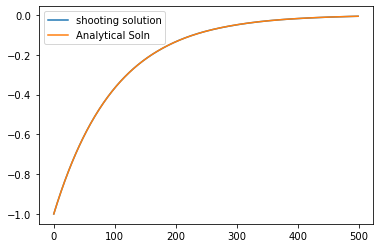

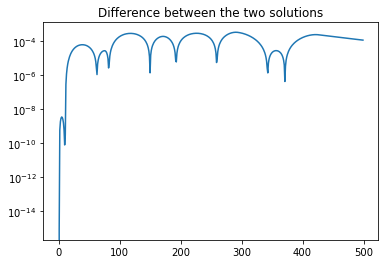

In [58]:
def eq(x,v):
    factor =1.6e-19*1.6e-19*6.022e23*(4e-3+4e-3)/(80.4*1.38e-23*298)
    return np.array([v[1],v[0]])

def shootmenowplis(v0):
    
    x = np.linspace(0,5,500)
    
    bc = lambda va,vb : np.array([va[0] - v0, vb[0]])
    
    #self defined shooting method
    sol1 = scipy.integrate.solve_ivp(eq,(0,5),[v0,0],t_eval = x)
    sol2 = scipy.integrate.solve_ivp(eq,(0,5),[0,1],t_eval = x)
    factor = - sol1.y[1][-1]/sol2.y[0][-1]
    finsol = sol1.y + (factor*sol2.y)
    
    linsol = lambda z: v0*np.exp(-z)
    analyticalsoln = linsol(x)
    
    plt.plot(finsol[0])
    plt.plot(analyticalsoln)

    plt.legend(["shooting solution","Analytical Soln"])
    plt.show()
    
    diff = np.abs(finsol[0] - analyticalsoln)
    
    plt.plot(diff)
    plt.title("Difference between the two solutions")
    plt.yscale("log")

    return
    
shootmenowplis(-1)

Both solutions almost perfectly overlap, so the shooting method works quite fine for the linear simplification of the solution. Bear in mind that for the solution to be reasonably accurate when compared to the full solution, the v value should preferably be less than 0.01 (two orders of magnitude lower than the non-dimensionalising thermal potential).

Solving in a fully numerical way by using finite difference method is the next way to go. The same physical parameters have been used for solving this problem too. Central difference scheme has been used for the internal nodes, while the boundary conditions are dirichlet at x = 0, and Neumann at x = 1, which has been approximated as a forward difference

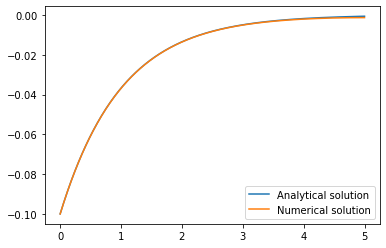

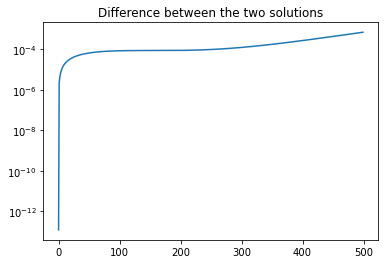

In [48]:
def findAmatrix(size):
    a = np.zeros((size,size))
    h = 5/size
    for i in range(1,size-1):
        a[i][i-1] = 1/(h*h)
        a[i][i] = -(2/(h*h))-1
        a[i][i+1] = 1/(h*h)
    
    a[0][0] = 1
    a[-1][-1] = 1
    a[-1][-2] = -1
    
    return a

def numerical1Dsol(v0):
    
    size = 500
    f = np.zeros(size)
    f[0] = v0
    a = findAmatrix(size)
    v = np.linalg.solve(a,f)
    axis = np.linspace(0,5,size)
    z = np.linspace(0,5,500)
    linsol = lambda x: v0*np.exp(-x)
    
    v2 = linsol(z)
    plt.plot(z,v2)
    plt.plot(axis,v)
    
    plt.legend(["Analytical solution","Numerical solution"])
    
    plt.show()
    
    diff = np.abs(v2 - v)
    
    plt.plot(diff)
    plt.title("Difference between the two solutions")
    plt.yscale("log")
    return
numerical1Dsol(-0.1)

Again, the numerical and the analytical solutions almost perfectly overlap, so they seem to work quite well too. The relative error does go up as we approach the end boundary condition, but is still relatively small and insignificant

In [ ]:
# Insert pypde soln here

Non-linear solutions follow below. For cases where the wall potential is higher, a steeper gradient is to be expected and the same linearisation of problem cannot be expected to hold

#1. Solving the non-linear problem for the simplified case of a 1:1 electrolyte. The 1:1 here is not as important as the magnitude of z+ and z- being the same, z can have other values too. This makes the non-dimensionalisation of the equation easier. This assumption is behind the solution now known as the Guoy-Chapman equation. We are only plotting the equation, as the solution to this requires a few simplifications that neither sympy, nor wolfram for that matter are performing.

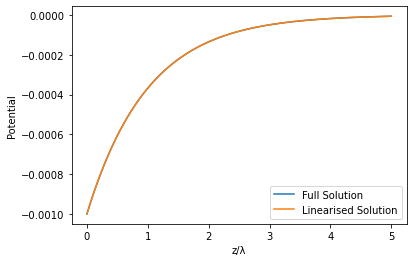

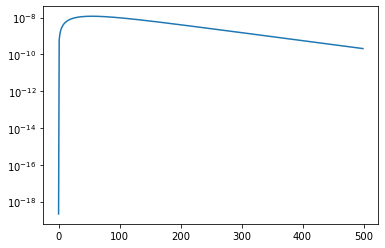

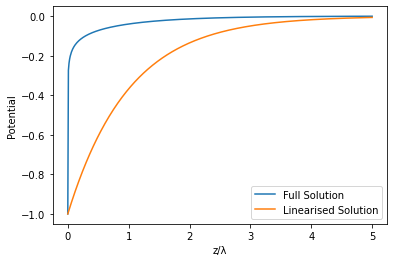

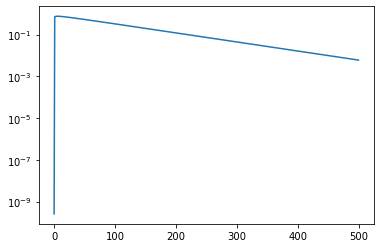

In [53]:
def plotsol(v0):
    z = np.linspace(0,5,500)
    fullsol = lambda x: 0.1035*np.arctanh(np.tanh(v0/0.1035)*np.exp(-x))
    v = fullsol(z)
    
    linsol = lambda x: v0*np.exp(-x)
    v2 = linsol(z)
    plt.plot(z,v)   
    plt.plot(z,v2)
    plt.legend(["Full Solution","Linearised Solution"])
    plt.xlabel("z/\u03BB")
    plt.ylabel("Potential")
    plt.show()
    
    diff = np.abs(v-v2)
    plt.plot(diff)
    plt.yscale("log")
    plt.show()
    return

plotsol(-0.001)


plotsol(-1)


The same non-dimensionalising parameters have been used for both equations. The difference from the previous solutions is that here the wall potential non-dimensionalising parameter is 4*kT/e, which equates to 0.1035V. So long as the wall potential is at least one order of magnitude less than this, the linear solution seems to hold quite well. The difference in the solutions for larger wall potentials is plain to see

In [114]:
def eq(x,v):
    return np.array([v[1],np.sinh(v[0])])

# def shootmenowplis(v0):
    
#     x = np.linspace(0,5,500)
    
    
#     sol1 = scipy.integrate.solve_ivp(eq,t_span = (0,5),y0 = [v0,0],t_eval = x,rtol = 1e-6, atol = 1e-9)
    
# #     plt.plot(x,sol1.y[0])
    
    
#     sol2 = scipy.integrate.solve_ivp(eq,(0,5),[0,1],t_eval = x,vectorized = 'True')
    
#     print(sol1.t)
# #     print(len(sol1.y[0]),len(sol2.y[0]))
    
#     factor = - sol1.y[1][-1]/sol2.y[0][-1]
#     finsol = sol1.y + (factor*sol2.y)


# #     bc = lambda va,vb : np.array([va[0] - v0, vb[0]])
# #     initguess = np.zeros((2,len(x)))
# #     initguess[0] = v0
    
# #     finsol = scipy.integrate.solve_bvp(eq,bc,x,initguess)
    
#     fullsol = lambda z: 0.1035*np.arctanh(np.tanh(v0/0.1035)*np.exp(-z))
#     v = fullsol(x)
    
#     plt.plot(x,finsol[0])
#     plt.plot(x,v)
    
#     plt.legend(["Shooting Method","Analytical Soln"])
#     plt.show()
#     return

# shootmenowplis(-1)
def bc(u0,ub):
    return np.array([u0[0] - v0,ub[1]])

def trial(v0):
    
    x = np.linspace(0,5,500)
    
#     u_init = np.array([[v0,v0],[0,0]])

    res = scipy.integrate.solve_bvp(eq,bc,x,u_init)
    
    plt.plot(res.y[0])

    return
trial(-0.1)

ValueError: `y` is expected to have 500 columns, but actually has 2.

In [115]:
v = sp.Function("v")
z = sp.symbols("z")
a = sp.symbols("a")

eq = sp.Eq(v(z).diff(z,2) + a,0)

sol = sp.dsolve(eq)

sol

Eq(v(z), C1 + C2*z - a*z**2/2)